<img src="https://avatars.githubusercontent.com/u/74911464?s=200&v=4"
     alt="OpenEO Platform logo"
     style="float: left; margin-right: 10px;" />
# OpenEO Platform - UC9
Dynamic large area land cover mapping

In [1]:
import openeo
import geopandas as gpd
import pandas as pd
from openeo_classification.landuse_classification import *
from sklearn.model_selection import train_test_split
import json
from pathlib import Path
import xarray as xr

## Objectives and approach

In this notebook we will be studying land cover mapping. Land cover mapping has been done since the onset of remote sensing, and LC products have been identified as a fundamental variable needed for studying the functional and morphological changes occurring in the Earth's ecosystems and the environment, and plays therefore an important role in studying climate change and carbon circulation (Congalton et al., 2014; Feddema et al., 2005; Sellers et al., 1997). In addition to that, it provides valuable information for policy development and a wide range of applications within natural sciences and life sciences, making it one of the most widely studied applications within remote sensing (Yu et al., 2014; Yang et al., 2013; Running, 2008; Tucker et al., 1985). 

With this variety in application fields comes a variety of user needs. Depending on the use case, there may be large differences in the target labels desired, the target year(s) requested, the output resolution needed, the feature set used, the stratification strategy employed, and more. The goal of this use case is to show that openEO as a platform can deal with this variability, and we will do so through creating a user-friendly interface in which the user can set a variety of parameters that will tailor the land use classification pipeline to the user’s needs.

## Methodology

#### Reference data 
The reference dataset used in this project is the Land Use/Cover Area frame Survey (LUCAS) Copernicus dataset. LUCAS is an evenly spaced in-situ land use and land cover ground survey exercise that extends over the entire of the European Union. The Copernicus module extends up to 51m in four cardinal directions to delineate polygons for each of these points. The final product contains about 60,000 polygons, from which subsequent points can be sampled (d'Andrimont et al., 2021). The user can specify how many points to sample from these polygons to train his model. In addition, the user can upload extra target data to improve performance.

#### Input data
The service created runs on features constructed from GRD sigma0 and L2A data. This data will be accessed through OpenEO platform from Terrascope and  SentinelHub. The extracted data stems from 01-01-2018 to 31-12-2018, corresponding to the year of collection of the LUCAS dataset (2018) on the basis of which the model was trained. Data from other years can be extracted for prediction, provided that the user uploads their own reference set.

#### Preprocessing
The L2A data has been masked using the sen2cor sceneclassification, with a buffering approach developed at VITO and made available as a process called mask_scl_dilation. From the Sentinel-1 GRD collection, backscatter is calculated.

#### Feature engineering
We select and calculate the following products from our input collections:
- 7 indices (NDVI, NDMI, NDGI, ANIR, NDRE1, NDRE2, NDRE5) and 2 bands (B06, B12) from the L2A collection
- VV, VH and VV/VH (ratio) from the GRD sigma0 collection

As you user you are however free to select other S2 indices; if you are interested in doing so, please refer to the [advanced notebook](https://github.com/openEOPlatform/SRR3_notebooks/blob/main/notebooks/Demo%20UC9%20with%20stratification.ipynb).

All layers are rescaled to 0 to 30000 for computational efficiency. The indices/bands are then aggregated temporally (for Sentinel-2 data: 10-day window using the median. For Sentinel-1 data: 12 day window using the mean. The median was used for the S2 collection instead of the mean to prevent possible artifacts caused by cloud shadows). The output is then interpolated linearly and the S1 cube is resampled spatially to a 10m resolution. Finally, 10 features are calculated on each of the band dimensions. These 10 features are the standard deviation, 25th, 50th and 75th percentile, and 6 equidistant t-steps. Through this procedure, we end up with a total of 120 features (12 bands x 10 features).

#### Model
Where previously models had to be trained outside of openEO, we can now train Random Forest models in openEO itself. Hyperparameter tuning can be performed using a custom hyperparameter set. After training, the model is validated and used for prediction.

## Implementation
First, create an area of interest for which you want do this classification, and potentially a stratification layer if you would like to make use of stratification. Tune the other parameters to your personal preference.

In [2]:
split, algorithm, nrtrees, fusion_technique, aoi_sampling, aoi_inference, start_date, end_date, nr_targets, nr_samples_per_polygon = get_starting_widgets()

Box(children=(Label(value='Train / test split:'), FloatSlider(value=0.75, max=1.0, step=0.05)))

Dropdown(description='Model:', disabled=True, options=('Random Forest',), value='Random Forest')

Box(children=(Label(value='Hyperparameters RF model:'), IntText(value=200, description='Nr trees:')))

Box(children=(Label(value='S1 / S2 fusion:'), RadioButtons(disabled=True, options=('Feature fusion', 'Decision…

FileUpload(value={}, accept='.geojson,.shp', description='Upload AOI sampling', layout=Layout(width='20em'))

FileUpload(value={}, accept='.geojson,.shp', description='Upload AOI inference', layout=Layout(width='20em'))

DatePicker(value=datetime.date(2018, 3, 1), description='Start date')

DatePicker(value=datetime.date(2018, 10, 31), description='End date')

Box(children=(Label(value='Select the amount of target classes:'), IntSlider(value=8, max=37, min=2)))

Box(children=(Label(value='Select the amount of times you want to point sample each reference polygon:'), IntS…

Select your final target classes

In [3]:
target_classes = get_target_classes(nr_targets)

SelectMultiple(description='Target class', options=('A00: Artificial land', 'A10: Roofed built-up areas', 'A20…

Text(value='Label 1', description='Label 1:', placeholder='Give your subselection a label')

SelectMultiple(description='Target class', options=('A00: Artificial land', 'A10: Roofed built-up areas', 'A20…

Text(value='Label 2', description='Label 2:', placeholder='Give your subselection a label')

SelectMultiple(description='Target class', options=('A00: Artificial land', 'A10: Roofed built-up areas', 'A20…

Text(value='Label 3', description='Label 3:', placeholder='Give your subselection a label')

### TRAINING

We will first load in the LUCAS Copernicus dataset for your specific target area.

In [4]:
y = get_reference_set(aoi_sampling, nr_samples_per_polygon, target_classes)

Loading in the LUCAS Copernicus dataset...
Finished loading data.
Extracting points and converting target labels...
We transformed your labels into numerical, as the Random Forest model expects numerical values. The mapping is:
                      Target value
Label                             
Built-up                         0
Cropland                         1
Woodland & Shrubland             2
Finished extracting points and converting target labels


In [5]:
y = y.drop(["LC1"],axis=1)
y.head()

,geometry,target
0,POINT (9.35367 42.81445),2
1,POINT (9.35324 42.86860),2
2,POINT (7.57007 45.81907),2
3,POINT (7.73410 45.60643),2
4,POINT (8.49721 45.79977),2


We can have a look at the amount of LUCAS samples that were present within this final reference set.

In [12]:
y.groupby("target").count()

,geometry
target,
0,329
1,1126
2,640


The LUCAS dataset is imbalanced. That is why it can be useful for some use cases to gather some extra reference data, and append that to the LUCAS reference data. This is something that has been done in the *Demo UC9 with stratification* notebook.

To counteract this class imbalance, we can also decide to sample a larger area and then apply one of various sampling strategies. As this is just another pandas.DataFrame, you can do this in many different ways. One way to perform this sampling is to use the .sample method of pandas.DataFrame

In [81]:
g = y.groupby('target')
y_balanced = g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True))
y_balanced.index = range(len(y_balanced))

In [82]:
y_balanced.groupby("target").count()

,geometry
target,
0,329
1,329
2,329


We then split our reference data into a training and a test set. If you wish, you can include a validation set as well.

In [7]:
y_train, y_test = train_test_split(y, test_size=(1-split.value), random_state=333)

We will now load in the features. The feature set is made up of 7 indices calculated from S2, two S2 bands, two S1 bands and one index calculated from S1. More information on the exact feature calculation can be found in the use case demonstration report.

In [8]:
job_opts = {
    "indexreduction": 0,
    "temporalresolution": "None",
    "tile_size": 128,
}

features, feature_list = load_lc_features("terrascope", "both", start_date.value, end_date.value,
                                         processing_opts=job_opts)

X = features.aggregate_spatial(json.loads(y_train.to_json()), reducer="mean")
ml_model = X.fit_class_random_forest(
    target=json.loads(y_train.to_json()), 
    num_trees=nrtrees.value
)
model = ml_model.save_ml_model()
training_job = model.create_job()
training_job.start_and_wait()

Authenticated using refresh token.
['NDVI', 'NDMI', 'NDGI', 'NDRE1', 'NDRE2', 'NDRE5', 'ANIR']
Authenticated using refresh token.
0:00:00 Job 'j-0cc348f80cf640ddb7d2077f85ff4dc5': send 'start'
0:02:21 Job 'j-0cc348f80cf640ddb7d2077f85ff4dc5': queued (progress N/A)
0:02:27 Job 'j-0cc348f80cf640ddb7d2077f85ff4dc5': queued (progress N/A)
0:02:34 Job 'j-0cc348f80cf640ddb7d2077f85ff4dc5': queued (progress N/A)
0:02:43 Job 'j-0cc348f80cf640ddb7d2077f85ff4dc5': queued (progress N/A)
0:02:53 Job 'j-0cc348f80cf640ddb7d2077f85ff4dc5': queued (progress N/A)
0:03:06 Job 'j-0cc348f80cf640ddb7d2077f85ff4dc5': queued (progress N/A)
0:03:22 Job 'j-0cc348f80cf640ddb7d2077f85ff4dc5': queued (progress N/A)
0:03:42 Job 'j-0cc348f80cf640ddb7d2077f85ff4dc5': queued (progress N/A)
0:04:06 Job 'j-0cc348f80cf640ddb7d2077f85ff4dc5': queued (progress N/A)
0:04:37 Job 'j-0cc348f80cf640ddb7d2077f85ff4dc5': queued (progress N/A)
0:05:14 Job 'j-0cc348f80cf640ddb7d2077f85ff4dc5': running (progress N/A)
0:06:02 Job 'j

<RESTJob job_id='j-0cc348f80cf640ddb7d2077f85ff4dc5'>

We will now start fitting the model. As we are using feature fusion, the S1 and S2 features will be merged, and only one model will be trained over all features combined. However, if you are using stratification, you will be constructing a separate model for every stratum within your AOI (i.e., your AOI contains a field named "stratum" that has various rows with different values). Stratification is not done in this notebook, but if that interests you, have a look at the *Demo UC9 with stratification* notebook.

If you don't want to run this step and start with a pretrained model, you can take one of the following models and pass the job ID to the model parameter of predict_random_forest:
- a 1-stratum model for Belgium: 8f18a3f8-458f-4e78-80d8-88341ee3af52
- a 1-stratum model for Italy: 870fd274-b206-4ddd-b5c8-a1a459bc6696
- a 2-stratum model for Spain;
    - stratum 1 (43000.0): 93ad21c3-dada-46a0-873d-13dd8d30f486
    - stratum 2 (46000.0): 1ddf23e5-212a-4883-b4a0-29a85ef9b363

After training the respective models, we can do inference. In general you would like to first do inference on a test set, so that you can calculate a number of accuracy metrics, such as the overall accuracy, the F-score, and/or creating a confusion matrix.

In [ ]:
base_path = Path.cwd() / "results" / "testarea"
validation_path = base_path / "validation"
validation_path.mkdir(parents=True,exist_ok=True)

y_test.to_file(filename=str(validation_path / 'y_test.geojson'),driver="GeoJSON")
cube = features.filter_spatial(json.loads(buf(y_test["geometry"]).to_json()))
predicted = cube.predict_random_forest(
    model=training_job,
    dimension="bands"
).linear_scale_range(0,255,0,255)
test_job = predicted.execute_batch(
    title="Validation for prediction in testarea Belgium",
    out_format="netCDF"
)
test_job.get_results().download_files(str(validation_path))

We can then calculate a number of validation metrics, such as the accuracy and the F-score from the test set. You can use the geodataframe containing the target label and target prediction for calculating these metrics.

The total amount of test samples you supplied is 186. Of these, 1 could not be matched to the coordinates of your y samples. If this is more than a few samples, please check if your CRS is aligned.
Accuracy on test set: 0.8


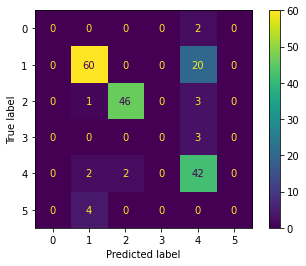

In [3]:
gdf, final_res = calculate_validation_metrics(
    path_to_test_geojson=str(validation_path / 'y_test.geojson'),
    path_to_test_raster=str(validation_path / "openEO.nc"))

### PREDICTION

Finally, if you are satisfied with the scores you obtained, we can do inference over your AOI of inference specified.

In [36]:
features, feature_list = load_lc_features("terrascope", "both", start_date.value, end_date.value, processing_opts=dict(tile_size=256))

cube = features.filter_spatial(json.loads(aoi_inference.data[0]))
predicted = cube.predict_random_forest(
    model=training_job,
    dimension="bands"
).linear_scale_range(0,255,0,255)
inf_job = predicted.execute_batch(out_format="GTiff")
inf_job.get_results().download_files(str(base_path / "prediction"))

Authenticated using refresh token.
Authenticated using refresh token.
0:00:00 Job '37560156-cddd-4102-9dda-36bc78b6cf32': send 'start'
0:01:30 Job '37560156-cddd-4102-9dda-36bc78b6cf32': queued (progress N/A)
0:01:35 Job '37560156-cddd-4102-9dda-36bc78b6cf32': queued (progress N/A)
0:01:42 Job '37560156-cddd-4102-9dda-36bc78b6cf32': queued (progress N/A)
0:01:50 Job '37560156-cddd-4102-9dda-36bc78b6cf32': queued (progress N/A)
0:02:00 Job '37560156-cddd-4102-9dda-36bc78b6cf32': queued (progress N/A)
0:02:13 Job '37560156-cddd-4102-9dda-36bc78b6cf32': queued (progress N/A)
0:02:29 Job '37560156-cddd-4102-9dda-36bc78b6cf32': queued (progress N/A)
0:02:48 Job '37560156-cddd-4102-9dda-36bc78b6cf32': queued (progress N/A)
0:03:13 Job '37560156-cddd-4102-9dda-36bc78b6cf32': queued (progress N/A)
0:03:43 Job '37560156-cddd-4102-9dda-36bc78b6cf32': running (progress N/A)
0:04:21 Job '37560156-cddd-4102-9dda-36bc78b6cf32': running (progress N/A)
0:05:08 Job '37560156-cddd-4102-9dda-36bc78b6cf32

[WindowsPath('C:/Users/DRIESSEB/Dev/SRR3_notebooks/notebooks/results/testarea/prediction/openEO.nc')]

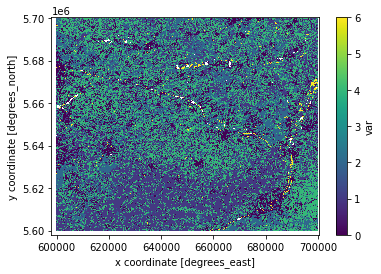

In [41]:
ds = xr.open_dataset(str(base_path / "prediction" / "openEO.nc"))
ds_transform_na = ds["var"].astype(int).where(ds_int < 20)
ds_transform_na.plot.imshow()

## References
d'Andrimont, Raphaël, et al., 2021. "LUCAS Copernicus 2018: Earth-observation-relevant in situ data on land cover and use throughout the European Union." Earth System Science Data 13.3 (2021): 1119-1133.

Congalton, R. G., Gu, J., Yadav, K., Thenkabail, P., & Ozdogan, M. (2014). Global land cover mapping: A review and uncertainty analysis. Remote Sensing, 6(12), 12070-12093.

Feddema, J. J., Oleson, K. W., Bonan, G. B., Mearns, L. O., Buja, L. E., Meehl, G. A., & Washington, W. M. (2005). The importance of land-cover change in simulating future climates. Science, 310(5754), 1674-1678.

Running, S. W. (2008). Ecosystem disturbance, carbon, and climate. Science, 321(5889), 652-653.

Sellers, P. J., Dickinson, R. E., Randall, D. A., Betts, A. K., Hall, F. G., Berry, J. A., ... & Henderson-Sellers, A. (1997). Modeling the exchanges of energy, water, and carbon between continents and the atmosphere. Science, 275(5299), 502-509.

Tucker, C. J., Townshend, J. R., & Goff, T. E. (1985). African land-cover classification using satellite data. Science, 227(4685), 369-375.

Yang, J., Gong, P., Fu, R., Zhang, M., Chen, J., Liang, S., ... & Dickinson, R. (2013). The role of satellite remote sensing in climate change studies. Nature climate change, 3(10), 875-883.

Yu, L., Liang, L., Wang, J., Zhao, Y., Cheng, Q., Hu, L., ... & Gong, P. (2014). Meta-discoveries from a synthesis of satellite-based land-cover mapping research. International Journal of Remote Sensing, 35(13), 4573-4588.